# <center> 🧠 А нейронки будут? </center>

<img src="https://i.imgflip.com/1sdrv7.jpg" width="400" alt="NN_memes" align='right'/>
<br>

<p><font size="3" face="Arial" font-size="large"><ul type="square">
    
<li><a href="#c1">🛠 Реализация MLP из scikit-learn  </a></li>

<li><a href="#c2">🐍🔥 Самописный MLP на pytorch с двумя головами.</a></li>
<li><a href="#с3">🕸 TabNet </a>
<li><a href="#c4">🧠 Мысли и выводы</a>
<li><a href="#c5">🧸 Дополнительные материалы</a>

</li></ul></font></p>

<div class="alert alert-info">
    
* Предположим, вы достали все какие только можно визуализированные зависимости из ваших сырых данных, но на ум ничего дельного так и не пришло. \
* 

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Загружаем train-датасет который мы сохранили на шаге quickstart
rides_info = pd.read_csv('../data/quickstart_train.csv')
rides_info.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,4.737759,1.214131e+07,0.1,180.855726,0.023174,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,4.480517,1.803909e+07,0.0,187.862734,12.306011,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,4.768391,1.588366e+07,0.1,102.382857,2.513319,174,173
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,32.22,engine_fuel,3.880920,1.651883e+07,0.1,172.793237,-5.029476,174,170
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,27.51,engine_fuel,4.181149,1.398317e+07,0.1,203.462289,-14.260456,174,171


In [3]:
drop_cols = ['car_id', 'target_reg', 'target_class']
cat_cols = ['car_type', 'fuel_type', 'model']

In [4]:
# закодируем категориальные фичи в one hot encoding вектора
rides_info = pd.get_dummies(rides_info, columns=cat_cols)

In [5]:
# заполним пропущенные значения медианным значением по столбцу
rides_info.fillna(rides_info.median(), inplace=True)

/tmp/ipykernel_84891/2067634496.py:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  rides_info.fillna(rides_info.median(), inplace=True)


## <center>🛠 Готовая реализация нейронной сети MLP из `sklearn`.</center>

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import f1_score, mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [7]:
# переведем строковые значения категориального таргета в целочисленные
le = LabelEncoder()
rides_info['target_class'] = le.fit_transform(rides_info['target_class'])

In [8]:
# числовые переменные, которые подвергнем трансформации
num_cols = [col for col in list(rides_info.columns)
            if col not in drop_cols]

In [9]:
# для нормализации данных используем robust scaler
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

df = scaler.fit_transform(rides_info[num_cols])
df = pd.DataFrame(df, columns=num_cols)

target_scaler = RobustScaler()
target = target_scaler.fit_transform(rides_info['target_reg'].values.reshape(-1, 1))

df['target_reg'] = target
df['target_class'] = rides_info['target_class']

In [10]:
X = df.drop(['target_class','target_reg'], axis=1)
y = df['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Классификация**

In [17]:
clf = MLPClassifier(random_state=42, max_iter=20, verbose=5).fit(X_train, y_train)

Iteration 1, loss = 2.16891360
Iteration 2, loss = 2.06997601
Iteration 3, loss = 1.98756890
Iteration 4, loss = 1.91333799
Iteration 5, loss = 1.84459997
Iteration 6, loss = 1.77749716
Iteration 7, loss = 1.71341305
Iteration 8, loss = 1.64966392
Iteration 9, loss = 1.58735378
Iteration 10, loss = 1.52739432
Iteration 11, loss = 1.46963852
Iteration 12, loss = 1.41371104
Iteration 13, loss = 1.36085464
Iteration 14, loss = 1.31114046
Iteration 15, loss = 1.26409271
Iteration 16, loss = 1.22127515
Iteration 17, loss = 1.18107583
Iteration 18, loss = 1.14461299
Iteration 19, loss = 1.11049582
Iteration 20, loss = 1.07955570


/home/jovyan/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


In [18]:
preds = clf.predict(X_test)

In [19]:
preds[:5]

array([4, 6, 6, 6, 2])

In [20]:
f1_score(y_test, preds, average='macro')

0.5425973554929262

In [21]:
accuracy_score(y_test, preds)

0.5726495726495726

## **Регрессия**

In [22]:
y = df['target_reg']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
regr = MLPRegressor(random_state=42, max_iter=50).fit(X_train, y_train)

/home/jovyan/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [26]:
preds = regr.predict(X_test)
preds = target_scaler.inverse_transform(np.array(preds).reshape(-1, 1))
preds[:5]

array([[72.71671533],
       [32.84617531],
       [53.26113851],
       [49.94877966],
       [35.87741341]])

In [27]:
mean_squared_error(y_test, preds) ** 0.5

45.938741736955315

<div class="alert alert-info">
    
* Мало возможностей для кастомизации
* Плохо работает с дефолтными параметрами
* 

## <center>🐍🔥 Двух головая нейронка на `PyTorch`.</center>
Теперь попробуем решить задачу с помощью самописного MLP с двумя головами на фрэймворке PyTorch.

In [28]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [29]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import os
import copy

In [30]:
# для наших данных и размера нейросети подойдет запуск на cpu
device = torch.device('cpu')

In [31]:
# ВАЖНО! - фиксируем воспроизводимость
def seed_everything(seed=42):
    
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [32]:
# можно попробовать поэкспериментировать с параметрами
class CFG:
    hidden_size=128
    dropout=0.1
    lr=1e-3
    batch_size=128
    num_workers=4
    epochs=20
    num_features=train.shape[1]-2 # кол-во фичей подаваемое на вход
    num_tar_class=train.target_class.nunique() # количество выходов равно кол-ву предсказываемых классов

In [33]:
# датасет выдает фичи и значения целевых переменных
class Rides(Dataset):
    
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx,:]
        
        data = row.drop(labels=['target_reg', 'target_class'])
        
        data = torch.FloatTensor(data.values.astype('float'))
        tar_reg = torch.tensor(row['target_reg']).float()
        tar_class = row['target_class'].astype('int')
        
        return data, tar_reg, tar_class

In [34]:
# проверим корректность работы методов нашего класса
next(iter(Rides(train)))

(tensor([-0.7302, -1.5000, -1.4019,  1.0000,  0.2215, -0.1615, -0.1000,  0.4241,
         -0.2246,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000]),
 tensor(-0.6091),
 2)

In [35]:
train_datasets = {'train': Rides(train),
                  'val': Rides(test)}

In [36]:
dataloaders_dict = {x: torch.utils.data.DataLoader(train_datasets[x], 
                                                   batch_size=CFG.batch_size, 
                                                   shuffle=True, 
                                                   num_workers=CFG.num_workers)
                    for x in ['train', 'val']}

In [37]:
# Построим архитектуру mlp с двумя головами для регрессии и классифкации

class TabularNN(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.mlp = nn.Sequential(
                          nn.Linear(cfg.num_features, cfg.hidden_size),
                          #nn.BatchNorm1d(cfg.hidden_size),
                          nn.Dropout(cfg.dropout),
                          nn.ReLU(),
                          nn.Linear(cfg.hidden_size, cfg.hidden_size),
                          #nn.BatchNorm1d(cfg.hidden_size),
                          nn.Dropout(cfg.dropout),
                          nn.ReLU(),
                          nn.Linear(cfg.hidden_size, cfg.hidden_size//2),
                          )
        
        self.regressor = nn.Sequential(
            nn.Linear(cfg.hidden_size // 2, 1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(cfg.hidden_size // 2, cfg.num_tar_class)
        )

    def forward(self, data):
        x = self.mlp(data)
        tar_reg = self.regressor(x)
        tar_class = self.classifier(x)
        return tar_reg.view(-1), tar_class

In [38]:
model = TabularNN(CFG).to(device)

In [39]:
# оптимайзер и лоссы для регрессии и классификации
optimizer = torch.optim.Adam(model.parameters(), lr = CFG.lr)
regression_criterion = nn.MSELoss().to(device)
classification_criterion = nn.CrossEntropyLoss().to(device)

In [71]:
# функция для тренировки, на выходе - обученная модель
def train_model(model, dataloaders, regression_criterion,
                classification_criterion, optimizer, num_epochs=25,
                early_stopping_rounds=5, verbose=2):

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    early_steps = 0
    stop = False

    for epoch in range(num_epochs):
        if stop:
            break
        if epoch % verbose == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels_1, labels_2 in dataloaders[phase]:
                inputs = inputs.to(device)
                labels_1 = labels_1.to(device)
                labels_2 = labels_2.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss

                    outputs_1, outputs_2 = model(inputs)
                    loss_1 = regression_criterion(outputs_1, labels_1)
                    loss_2 = classification_criterion(outputs_2, labels_2)

                    loss = loss_1 + loss_2

                    _, preds_2 = torch.max(outputs_2, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                val_acc_history.append(running_loss)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            if epoch % verbose == 0:
                print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_model_wts = copy.deepcopy(model.state_dict())
                best_loss = epoch_loss
                early_steps = 0
            if phase == 'val' and epoch_loss > best_loss:
                early_steps += 1
                if early_steps > early_stopping_rounds:
                    stop = True
                    print(f'Stopped by early_stopping. Epoch: {epoch}')
                    break
               


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [72]:
model_ft = train_model(model, dataloaders_dict, regression_criterion,
                classification_criterion, optimizer, num_epochs=22)

Epoch 0/21
----------
train Loss: 0.9323
val Loss: 1.1543
Epoch 2/21
----------
train Loss: 0.9130
val Loss: 1.1567
Epoch 4/21
----------
train Loss: 0.9023
val Loss: 1.1384
Epoch 6/21
----------
train Loss: 0.8837
val Loss: 1.1636
Epoch 8/21
----------
train Loss: 0.8732
val Loss: 1.1420
Epoch 10/21
----------
train Loss: 0.8492
val Loss: 1.1783
Stopped by early_stopping. Epoch: 10


In [73]:
# p1, p2 - предсказания; l1, l2  - истинные значения

p1, p2, l1, l2 = [], [], [], []

with torch.set_grad_enabled(False):
    # Get model outputs and calculate loss
    for inputs, labels_1, labels_2 in dataloaders_dict['val']:
        inputs = inputs.to(device)
        labels_1 = labels_1.to(device)
        labels_2 = labels_2.to(device)
        l1.extend(labels_1.detach().cpu().numpy())
        l2.extend(labels_2.detach().cpu().numpy())
        
        outputs_1, outputs_2 = model_ft(inputs)
        _, outputs_2 = torch.max(outputs_2, 1)

        p1.extend(outputs_1.detach().cpu().numpy())
        p2.extend(outputs_2.detach().cpu().numpy())

In [77]:
# Сохраняем веса модели
torch.save(model_ft.state_dict(), 'tab_model.pth')

**посмотрим на результаты по каждой из задач**

In [74]:
# классификация
from sklearn.metrics import f1_score
f1_score(l2, p2, average='macro'), accuracy_score(l2, p2)

(0.6723428351666079, 0.6730769230769231)

In [75]:
p1 = target_scaler.inverse_transform(np.array(p2).reshape(-1, 1))
l1 = target_scaler.inverse_transform(np.array(l2).reshape(-1, 1))

In [76]:
# регрессия
mean_squared_error(l1, p1) ** 0.5

36.27338480915201

<div class="alert alert-info">

чтобы улучшить скор можно поэкспериментировать с: 
- нормализацией данных, заполнением пропусков
- архитектурой сети
- попробовать lr sheduler

<div class="alert alert-info">

Добавить выводы: 
* кастомизация без ограничений
* любые лоссы

# <center>🕸 `TabNet` - "SOTA" для табличек.</center>
А теперь решим задачу с помощью [TABNET](https://github.com/dreamquark-ai/tabnet).

https://arxiv.org/abs/1908.07442 <br>
[Подробное описание архитектуры на русском языке.](https://habr.com/ru/articles/540736/)

In [42]:
!pip install pytorch-tabnet -q

In [47]:
y = df['target_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Классификация**

In [49]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

clf = TabNetClassifier(device_name='cpu')
clf.fit(X_train.values, y_train,
        eval_set=[(X_test.values, y_test)])

/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.83062 | val_0_accuracy: 0.10256 |  0:00:00s
epoch 1  | loss: 2.60905 | val_0_accuracy: 0.11111 |  0:00:00s
epoch 2  | loss: 2.54789 | val_0_accuracy: 0.11538 |  0:00:00s
epoch 3  | loss: 2.44467 | val_0_accuracy: 0.12179 |  0:00:00s
epoch 4  | loss: 2.38623 | val_0_accuracy: 0.12179 |  0:00:00s
epoch 5  | loss: 2.31799 | val_0_accuracy: 0.11966 |  0:00:00s
epoch 6  | loss: 2.25361 | val_0_accuracy: 0.1047  |  0:00:00s
epoch 7  | loss: 2.23937 | val_0_accuracy: 0.12179 |  0:00:00s
epoch 8  | loss: 2.22423 | val_0_accuracy: 0.12393 |  0:00:00s
epoch 9  | loss: 2.19808 | val_0_accuracy: 0.13248 |  0:00:00s
epoch 10 | loss: 2.21252 | val_0_accuracy: 0.14103 |  0:00:00s
epoch 11 | loss: 2.19285 | val_0_accuracy: 0.14316 |  0:00:00s
epoch 12 | loss: 2.18451 | val_0_accuracy: 0.15598 |  0:00:00s
epoch 13 | loss: 2.1724  | val_0_accuracy: 0.16026 |  0:00:00s
epoch 14 | loss: 2.14659 | val_0_accuracy: 0.17949 |  0:00:00s
epoch 15 | loss: 2.14944 | val_0_accuracy: 0.19017 |  0

/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [50]:
for i, j in sorted(zip(clf.feature_importances_.astype('float16'), X_train.columns), reverse=True):
    print(i, j)

0.4966 mean_rating
0.2306 speed_max
0.1371 rating_min
0.0988 model_Hyundai Solaris
0.010254 model_Smart Coupe
0.00698 fuel_type_petrol
0.0048 riders
0.004036 model_Mini Cooper
0.001627 model_Audi A3
0.00147 model_Smart ForTwo
0.001165 user_ride_quality_median
0.0009565 distance_sum
0.0007944 model_Renault Kaptur
0.0007234 model_Skoda Rapid
0.0005913 model_Smart ForFour
0.0005627 year_to_work
0.000541 car_type_standart
0.0004168 model_Nissan Qashqai
0.0003915 model_Mercedes-Benz GLC
0.0003476 model_VW Polo
0.000232 car_type_business
0.0001805 year_to_start
0.0001553 model_VW Polo VI
0.0001531 car_rating
0.0001518 model_Mercedes-Benz E200
0.00011355 model_Kia Rio X-line
5.555e-05 model_Kia Sportage
3.505e-05 model_Tesla Model 3
3.18e-05 car_type_premium
2.396e-05 model_VW Tiguan
1.86e-05 model_BMW 320i
6.74e-06 model_Volkswagen ID.4 
6.74e-06 fuel_type_electro
5.8e-06 car_type_economy
0.0 user_uniq
0.0 model_Renault Sandero
0.0 model_MINI CooperSE
0.0 model_Kia Rio X
0.0 model_Kia Rio
0.

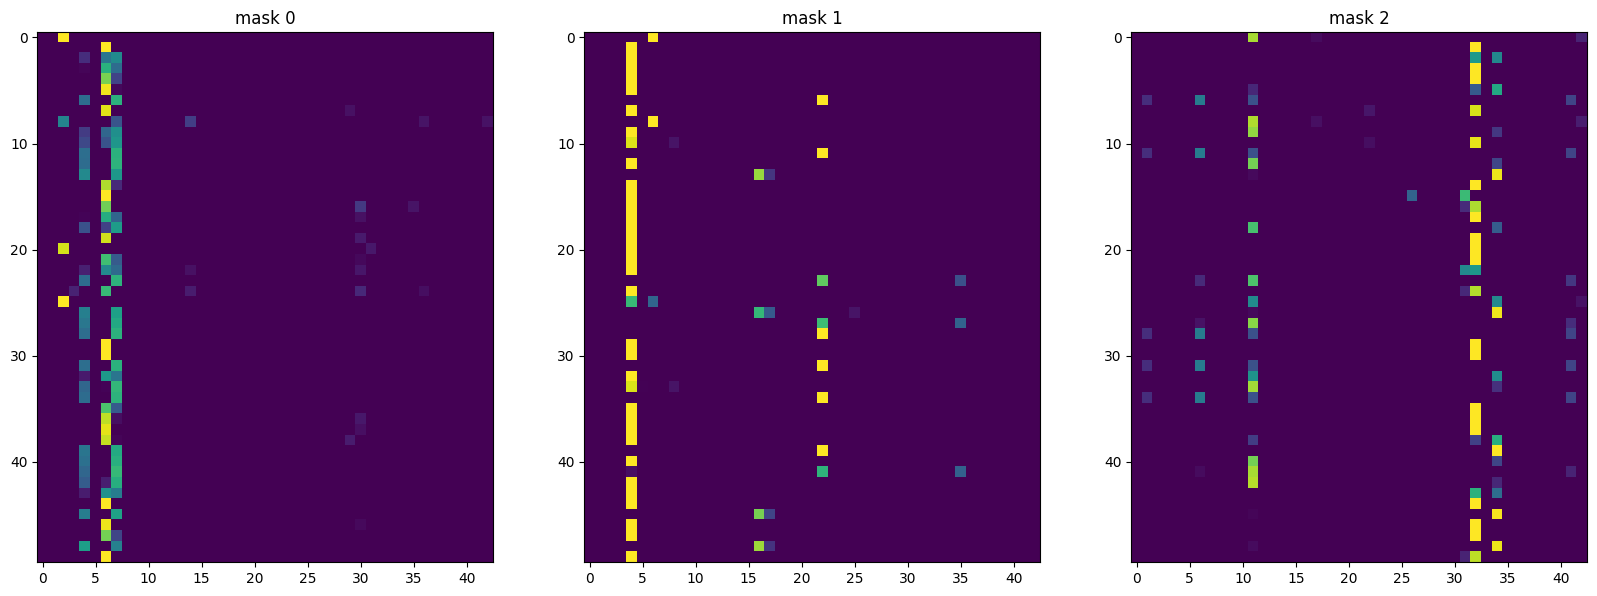

In [52]:
import matplotlib.pyplot as plt

explain_matrix, masks = clf.explain(X_test.values)

fig, axs = plt.subplots(1, 3, figsize=(20,20))
for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

In [53]:
preds = clf.predict(X_test.values)

In [54]:
preds[:5]

array([3, 5, 0, 6, 6])

In [55]:
f1_score(y_test, preds, average='macro'), accuracy_score(y_test, preds)

(0.5446759733706402, 0.5833333333333334)

## **Регрессия**

In [56]:
y = df['target_reg']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
reg = TabNetRegressor(device_name='cpu')
reg.fit(
  X_train.values, y_train.values.reshape(-1,1),
  eval_set=[(X_test.values, y_test.values.reshape(-1,1))]
)

/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.76506 | val_0_mse: 0.7045  |  0:00:00s
epoch 1  | loss: 1.2924  | val_0_mse: 0.68811 |  0:00:00s
epoch 2  | loss: 1.10533 | val_0_mse: 0.67619 |  0:00:00s
epoch 3  | loss: 0.94004 | val_0_mse: 0.67994 |  0:00:00s
epoch 4  | loss: 0.89023 | val_0_mse: 0.67594 |  0:00:00s
epoch 5  | loss: 0.80719 | val_0_mse: 0.67334 |  0:00:00s
epoch 6  | loss: 0.73245 | val_0_mse: 0.66269 |  0:00:00s
epoch 7  | loss: 0.75244 | val_0_mse: 0.65668 |  0:00:00s
epoch 8  | loss: 0.65909 | val_0_mse: 0.67951 |  0:00:00s
epoch 9  | loss: 0.62468 | val_0_mse: 1.07484 |  0:00:00s
epoch 10 | loss: 0.57264 | val_0_mse: 1.53159 |  0:00:00s
epoch 11 | loss: 0.58079 | val_0_mse: 1.77093 |  0:00:00s
epoch 12 | loss: 0.6089  | val_0_mse: 1.82843 |  0:00:00s
epoch 13 | loss: 0.64123 | val_0_mse: 1.9527  |  0:00:00s
epoch 14 | loss: 0.62013 | val_0_mse: 1.80956 |  0:00:00s
epoch 15 | loss: 0.59087 | val_0_mse: 1.843   |  0:00:00s
epoch 16 | loss: 0.57148 | val_0_mse: 1.88329 |  0:00:00s
epoch 17 | los

/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [62]:
preds = reg.predict(X_test.values)
preds = target_scaler.inverse_transform(np.array(preds).reshape(-1, 1))
preds[:5]

array([[41.067886],
       [41.123016],
       [40.908028],
       [40.900574],
       [41.344833]], dtype=float32)

In [63]:
mean_squared_error(y_test, preds) ** 0.5

40.50636571221867

<center> <img src='../images/nn1.png'> </center>

## <center>🧠 Мысли и выводы</center>


## <center>🧸 Дополнительные материалы</center>

* lifestream
* pytorch для табличек (добавить ссылки)